# Unsupervised Anomaly Detection on fastMRI


## Data Upload


In [1]:
# Download the data
#!wget https://syncandshare.lrz.de/dl/fiH6r4B6WyzAaxZXTEAYCE/data.zip
# Extract the data
#!unzip -q ./data.zip

## Imports


In [2]:
from model import CutPasteNet
from evaluate import Evaluator
from torch.utils.data import DataLoader
from data_loader import BrainMRI, MVTecAT, Repeat, collate_function

import matplotlib.pyplot as plt
import pytorch_lightning as pl

import warnings
warnings.filterwarnings("ignore")

import yaml
with open("./configs/model.yaml", "r") as f:
    config = yaml.safe_load(f)

%load_ext autoreload
%autoreload 2

In [3]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## Example Data Upload and Visualization


Using 581 IXI images and 130 fastMRI images. Total 711 images for training.


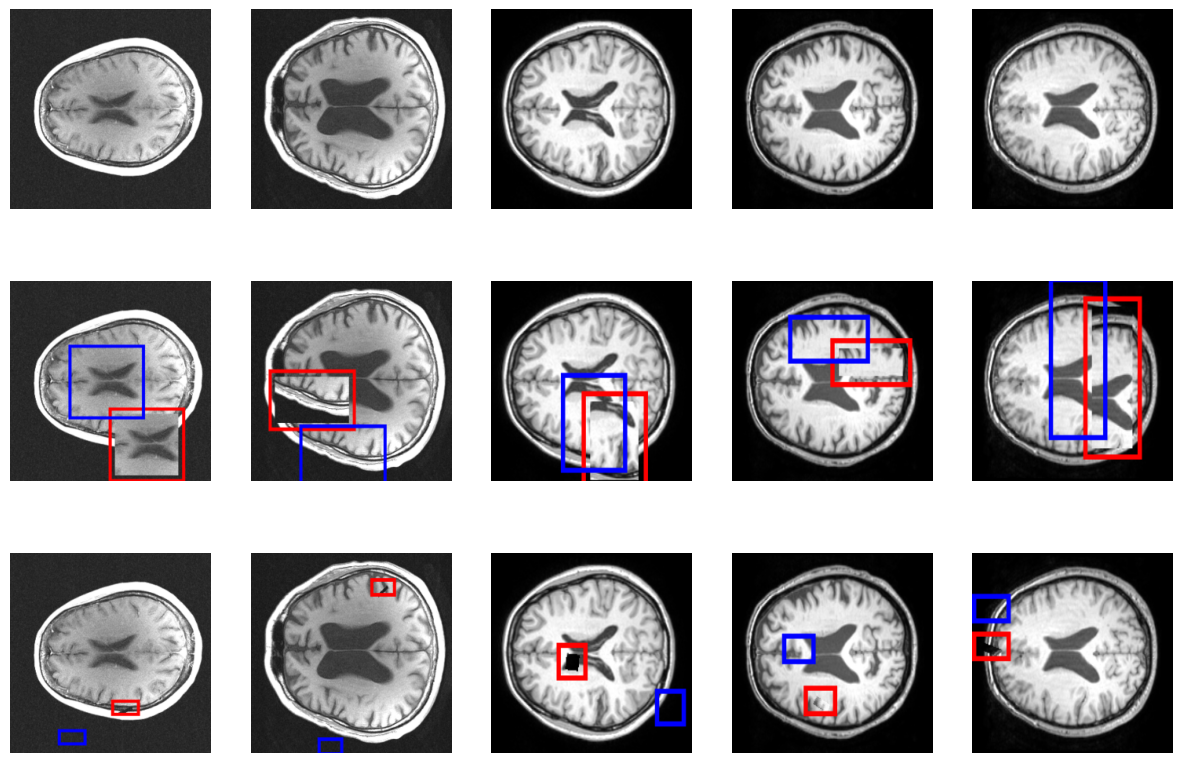

'\nmvtecat_train_dataloader = DataLoader(\n    MVTecAT(\n        root_dir="dataMVT",\n        defect_name="bottle",\n        size=config["target_size"],\n        mode="train",\n        cutpaste_type=config["cutpaste_type"],\n        data_display_mode=True,\n    ),\n    batch_size=128,\n    shuffle=True,\n    collate_fn=collate_function,\n)\n\nbatch = next(iter(mvtecat_train_dataloader))\nfig, ax = plt.subplots(3, 5, figsize=(15, 5))\nfor i in range(5):\n    ax[0][i].imshow(batch[0][i].T)\n    ax[0][i].axis("off")\n    ax[1][i].imshow(batch[1][i].T)\n    ax[1][i].axis("off")\n    ax[2][i].imshow(batch[2][i].T)\n    ax[2][i].axis("off")\nplt.show()\n'

In [4]:
train_data_loader = DataLoader(
    BrainMRI(
        split_dir=config["split_dir"],
        size=config["target_size"],
        mode="train",
        cutpaste_type=config["cutpaste_type"],
        data_display_mode=True,
    ),
    batch_size=config["batch_size"],
    shuffle=True,
    collate_fn=collate_function,
)

batch = next(iter(train_data_loader))
fig, ax = plt.subplots(3, 5, figsize=(15, 10))
for i in range(5):
    ax[0][i].imshow(batch[0][i].T)
    ax[0][i].axis("off")
    ax[1][i].imshow(batch[1][i].T)
    ax[1][i].axis("off")
    ax[2][i].imshow(batch[2][i].T)
    ax[2][i].axis("off")
plt.show()

"""
mvtecat_train_dataloader = DataLoader(
    MVTecAT(
        root_dir="dataMVT",
        defect_name="bottle",
        size=config["target_size"],
        mode="train",
        cutpaste_type=config["cutpaste_type"],
        data_display_mode=True,
    ),
    batch_size=128,
    shuffle=True,
    collate_fn=collate_function,
)

batch = next(iter(mvtecat_train_dataloader))
fig, ax = plt.subplots(3, 5, figsize=(15, 5))
for i in range(5):
    ax[0][i].imshow(batch[0][i].T)
    ax[0][i].axis("off")
    ax[1][i].imshow(batch[1][i].T)
    ax[1][i].axis("off")
    ax[2][i].imshow(batch[2][i].T)
    ax[2][i].axis("off")
plt.show()
"""

## Model Training


### Data Upload


In [5]:
brainMRI_train_data_loader = DataLoader(
    BrainMRI(
        split_dir=config["split_dir"],
        size=config["target_size"],
        mode="train",
        cutpaste_type=config["cutpaste_type"],
    ),
    batch_size=config["batch_size"],
    drop_last=True,
    shuffle=True,
    num_workers=8,
    collate_fn=collate_function,
)

Using 581 IXI images and 130 fastMRI images. Total 711 images for training.


## Prepare model


In [6]:
model = CutPasteNet(
    config,
    head_layer_count=2,
    num_classes=3 if config["cutpaste_type"] == "3way" else 2,
)

trainer = pl.Trainer(
    log_every_n_steps=4,
    max_epochs=config["num_epochs"],
    logger=[
        pl.loggers.CSVLogger(save_dir="./"),
        pl.loggers.TensorBoardLogger(save_dir="./"),
    ],
)

print("-----------------------------------------------")

trainer.fit(model, train_dataloaders=brainMRI_train_data_loader)

Selected device: mps


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | _RestNet18       | 11.8 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
11.8 M    Trainable params
0         Non-trainable params
11.8 M    Total params
47.081    Total estimated model params size (MB)


-----------------------------------------------
Epoch 255: 100%|██████████| 7/7 [01:35<00:00,  0.07it/s, v_num=8_39, train_loss=0.107, train_acc=0.965] 

`Trainer.fit` stopped: `max_epochs=256` reached.


Epoch 255: 100%|██████████| 7/7 [01:35<00:00,  0.07it/s, v_num=8_39, train_loss=0.107, train_acc=0.965]


## Evaluate Model


In [7]:
import json

model.eval()

pathology_mapping = {
    "absent_septum": "Absent Septum",
    "craniatomy": "Craniatomy",
    "dural": "Dural",
    "ea_mass": "EA Mass",
    "edema": "Edema",
    "encephalomalacia": "Encephalomalacia",
    "enlarged_ventricles": "Enlarged Ventricles",
    "intraventricular": "Intraventricular",
    "lesions": "Lesions",
    "mass": "Mass",
    "posttreatment": "Posttreatment",
    "resection": "Resection",
    "sinus": "Sinus",
    "wml": "WML",
    "other": "Other",
}

type_results = {}

for pathology in pathology_mapping:
    evaluator = Evaluator(
        model=model,
        device=model.deviceType,
        pathology=pathology,
        test_data_loader=DataLoader(
            BrainMRI(
                split_dir=config["split_dir"],
                size=config["target_size"],
                pathology=pathology,
                mode="test",
            ),
            batch_size=config["batch_size"],
            shuffle=True,
        ),
        output_dir=config["output_dir"],
    )

    print(f"Running {pathology_mapping[pathology]}...")
    roc_auc, dice_score, ap_score = evaluator.evaluate()
    type_results[pathology_mapping[pathology]] = {
        "ROC AUC": roc_auc,
        "Dice Score": dice_score.item(),
        "Average Precision": ap_score.item(),
    }


with open(config["output_dir"] + "/evaluation_results.json", "w") as fp:
    json.dump(type_results, fp)

Using 1 abnormal images and 30 normal images. Total 31 images for testing.
Running Absent Septum...
Dice score: 0.121
Average precision: 0.071
ROC AUC: 0.345
Using 15 abnormal images and 30 normal images. Total 45 images for testing.
Running Craniatomy...
Dice score: 0.525
Average precision: 0.788
ROC AUC: 0.853
Using 7 abnormal images and 30 normal images. Total 37 images for testing.
Running Dural...
Dice score: 0.356
Average precision: 0.530
ROC AUC: 0.772
Using 4 abnormal images and 30 normal images. Total 34 images for testing.
Running EA Mass...
Dice score: 0.256
Average precision: 0.278
ROC AUC: 0.648
Using 18 abnormal images and 30 normal images. Total 48 images for testing.
Running Edema...
Dice score: 0.567
Average precision: 0.692
ROC AUC: 0.775
Using 1 abnormal images and 30 normal images. Total 31 images for testing.
Running Encephalomalacia...
Dice score: 0.121
Average precision: 0.165
ROC AUC: 0.552
Using 19 abnormal images and 30 normal images. Total 49 images for testi

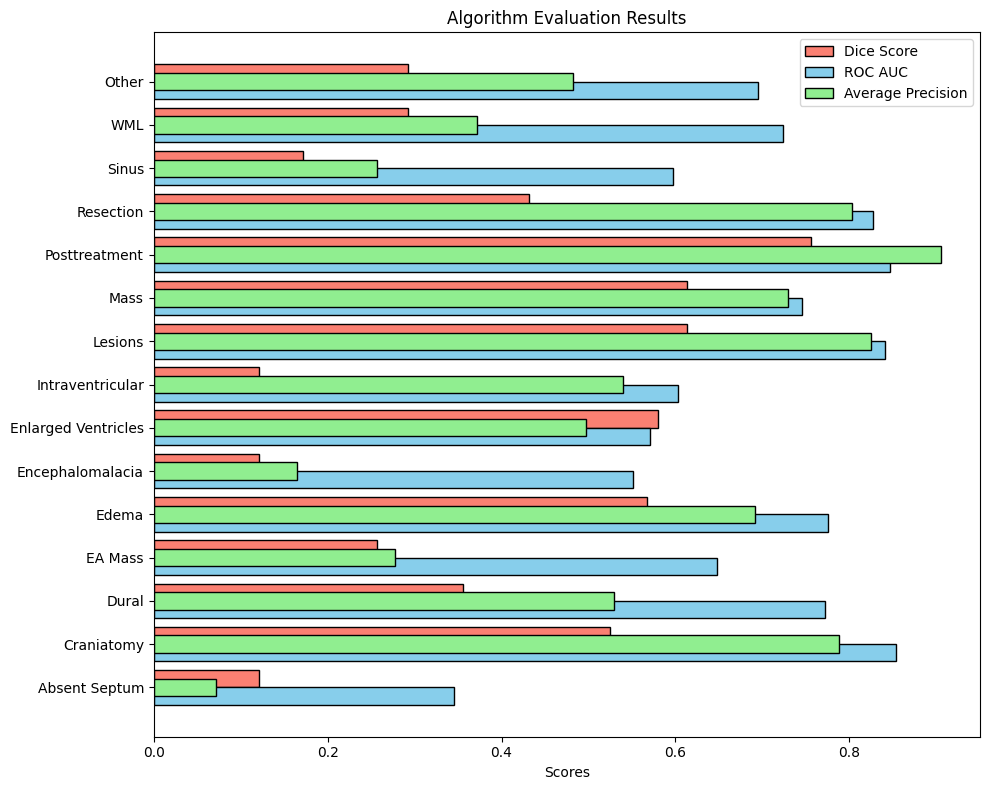

In [8]:
import matplotlib.pyplot as plt

pathologies = list(type_results.keys())
roc_auc_scores = [type_results[pathology]["ROC AUC"]
                  for pathology in pathologies]
dice_scores = [type_results[pathology]["Dice Score"]
               for pathology in pathologies]
ap_scores = [type_results[pathology]["Average Precision"]
             for pathology in pathologies]

plt.figure(figsize=(10, 8))

positions = range(len(pathologies))

# Plot Dice scores
plt.barh(
    [p + 0.2 for p in positions],
    dice_scores,
    color="salmon",
    edgecolor="black",
    height=0.4,
    label="Dice Score",
)
# Plot ROC AUC scores
plt.barh(
    [p - 0.2 for p in positions],
    roc_auc_scores,
    color="skyblue",
    edgecolor="black",
    height=0.4,
    label="ROC AUC",
)
# Plot Average Precision scores
plt.barh(
    positions,
    ap_scores,
    color="lightgreen",
    edgecolor="black",
    height=0.4,
    label="Average Precision",
)

plt.xlabel("Scores")
plt.title("Algorithm Evaluation Results")
plt.yticks(positions, pathologies)
plt.legend()
plt.tight_layout()
plt.savefig(config["output_dir"] + "/evaluation_results.png")

### GradCAM Anamoly Detection

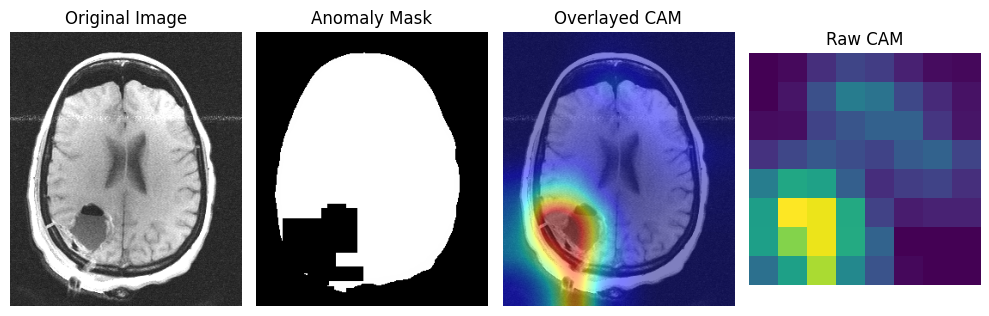

In [18]:
from PIL import Image
from torchcam.methods import GradCAM

from torchvision import transforms
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

transform = transforms.Compose(
    [transforms.Resize(config["target_size"]), transforms.ToTensor()]
)

modelGrad = model.model.resnet18

img_path = "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_6000518.png"
img = Image.open(img_path).convert("RGB")
input_tensor = transform(img)


with GradCAM(modelGrad) as cam_extractor:
    out = modelGrad(input_tensor.unsqueeze(0))
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].imshow(img)
ax[0].axis("off")
ax[0].set_title("Original Image")

mask_path = img_path.replace("brain_mid_png", "brain_mid_anno_neg_png")
ax[1].imshow(Image.open(mask_path).convert("RGB"))
ax[1].axis("off")
ax[1].set_title("Anomaly Mask")

ax[2].imshow(
    overlay_mask(img, to_pil_image(activation_map[0].squeeze(0), mode="F"), alpha=0.5)
)
ax[2].axis("off")
ax[2].set_title("Overlayed CAM")


ax[3].imshow(activation_map[0].squeeze(0).numpy())
ax[3].axis("off")
ax[3].set_title("Raw CAM")

plt.tight_layout()
plt.show()

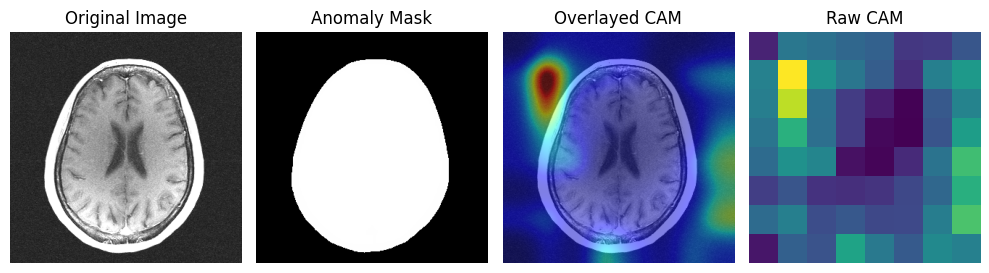

In [24]:
from PIL import Image
from torchcam.methods import GradCAM

from torchvision import transforms
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

transform = transforms.Compose(
    [transforms.Resize(config["target_size"]), transforms.ToTensor()]
)

modelGrad = model.model.resnet18
img_path = "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_2020024.png"
img = Image.open(img_path).convert("RGB")
input_tensor = transform(img)


with GradCAM(modelGrad) as cam_extractor:
    out = modelGrad(input_tensor.unsqueeze(0))
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].imshow(img)
ax[0].axis("off")
ax[0].set_title("Original Image")

mask_path = img_path.replace("file_brain_AXT1_202_2020024", "file_brain_AXT1_202_2020024_brain_map_full")
ax[1].imshow(Image.open(mask_path).convert("RGB"))
ax[1].axis("off")
ax[1].set_title("Anomaly Mask")

ax[2].imshow(
    overlay_mask(img, to_pil_image(activation_map[0].squeeze(0), mode="F"), alpha=0.5)
)
ax[2].axis("off")
ax[2].set_title("Overlayed CAM")


ax[3].imshow(activation_map[0].squeeze(0).numpy())
ax[3].axis("off")
ax[3].set_title("Raw CAM")

plt.tight_layout()
plt.show()